In [10]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import requests
from bs4 import BeautifulSoup

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import plotly.express as px

In [11]:
def lovely_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [12]:
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K'

# 1 Data
---
**Description**
| Column                      | Description                                         |
|-----------------------------|-----------------------------------------------------|
| Property                    | Identifier for the property.             |
| Current Monthly Payment     | Current monthly payment for the mortgage.|
| Current Loan Interest Rate (%) | Current interest rate for the mortgage.|
| Balance Left on Mortgage ($)| Outstanding balance on the mortgage.     |
| New Interest Rate (%)       | Proposed new interest rate if the mortgage is refinanced.|
| Remaining Loan Term (months)| Remaining term of the current mortgage in months. |
| New Loan Term (months)      | Proposed new term in months if the mortgage is refinanced. |
| Closing Cost ($)            | The cost associated with refinancing the mortgage.  |


In [13]:
data = pd.read_excel('Refinance model data.xlsx')
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors = 'coerce')
data = data.dropna()
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Refinance model data.xlsx'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 0 to 29
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Property                        29 non-null     object 
 1   Current Monthly Payment         29 non-null     int64  
 2   Current Loan Interest Rate (%)  29 non-null     float64
 3   Balance Left on Mortgage ($)    29 non-null     int64  
 4   New Interest Rate (%)           29 non-null     float64
 5   Remaining Loan Term (months)    29 non-null     object 
 6   New Loan Term (months)          29 non-null     int64  
 7   Closing Cost ($)                29 non-null     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 2.0+ KB


In [ ]:
data.describe()

,Current Monthly Payment,Current Loan Interest Rate (%),Balance Left on Mortgage ($),New Interest Rate (%),New Loan Term (months),Closing Cost ($)
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2331.034483,4.107759,280344.827586,3.599138,277.241379,5948.275862
std,504.340764,0.400508,93407.049238,0.360399,58.730410,1799.527853
min,1500.000000,3.500000,150000.000000,3.000000,180.000000,3500.000000
25%,1900.000000,3.875000,200000.000000,3.250000,240.000000,4500.000000
50%,2400.000000,4.000000,260000.000000,3.500000,300.000000,6000.000000
75%,2700.000000,4.250000,350000.000000,3.875000,300.000000,7500.000000
max,3200.000000,5.000000,500000.000000,4.250000,360.000000,10000.000000


# 2 Preparation

## 2.1 Functions

### Break Even Point Analysis
**Note**
- Only for thoes who want to lower their monthly payment.
  
---

  
1. Monthly Payment
The monthly payment is calculated using the following formula:  

<center>

$M = P \frac{r(1 + r)^n}{(1+r)^n - 1} $

</center>

where $M$ is the monthly payment, $P$ is the principal (Outstanding balance), $r$ is the monthly interest rate, and $n$ is the number of months.

2. Outstanding Balance
The outstanding balance is calculated using the following formula:

<center>

Outstanding Balance $= P \times (1 + r)^{(N-n)} - M \times \frac{(1 + r)^{(N-n)} - 1}{r} $

</center>


In [ ]:
def mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co):
    '''
    This function calculates and provides the break-even point, monthly savings, and new payment details, considering the closing costs and any cash-out during refinancing.
    
    Returns:
    - break_even_point : Number of months it will take to recoup the closing costs from monthly savings.
    - monthly_savings : Difference in monthly payment between the current and refinanced loan.
    - outstanding_principal_balance_adjusted : Adjusted outstanding principal balance after considering the cash-out amount.
    - current_monthly_payment : Monthly payment amount for the current loan.
    - new_monthly_payment : Monthly payment amount for the refinanced loan without considering the cash-out.
    - new_monthly_payment_adjusted : Monthly payment amount for the refinanced loan after considering the cash-out.

    '''

    
    if N is None:
        N = n
    if n is None:
        n = N
    
    principal = p  # Principal amount
    current_interest_rate = r  # Current interest rate
    current_total_term = N  # Current total term
    current_remaining_term = n  # Current remaining term
    new_interest_rate = new_r  # New interest rate
    new_remaining_term = new_n  # New remaining term
    closing_cost = c  # Closing cost
    cash_out = co  # Cash out amount
    
    # Monthly Payment for Current Mortgage
    current_monthly_interest_rate = current_interest_rate / 12 / 100
    current_monthly_payment = principal * current_monthly_interest_rate * (1 + current_monthly_interest_rate) ** current_total_term / ((1 + current_monthly_interest_rate) ** current_total_term - 1)
    
    # Outstanding Principal Balance
    outstanding_principal_balance = principal * (1 + current_monthly_interest_rate) ** (current_total_term - current_remaining_term) - (current_monthly_payment * ((1 + current_monthly_interest_rate) ** (current_total_term - current_remaining_term) - 1) / current_monthly_interest_rate)
    outstanding_principal_balance_adjusted = outstanding_principal_balance + cash_out
    
    # Monthly Payment for New Mortgage
    # new_monthly_payment: x cash_out
    new_monthly_interest_rate = new_interest_rate / 12 / 100
    new_monthly_payment = outstanding_principal_balance * new_monthly_interest_rate * (1 + new_monthly_interest_rate) ** new_remaining_term / ((1 + new_monthly_interest_rate) ** new_remaining_term - 1)
    new_monthly_payment_adjusted = outstanding_principal_balance_adjusted * new_monthly_interest_rate * (1 + new_monthly_interest_rate) ** new_remaining_term / ((1 + new_monthly_interest_rate) ** new_remaining_term - 1)
    
    # Monthly Payment Savings
    monthly_savings = current_monthly_payment - new_monthly_payment
    
    # Break Even Point
    break_even_point = closing_cost / monthly_savings
    return {
        'break_even_point': break_even_point,
        'monthly_savings': monthly_savings,
        'outstanding_principal_balance_adjusted': outstanding_principal_balance_adjusted, # v cash out
        'current_monthly_payment': current_monthly_payment,
        'new_monthly_payment': new_monthly_payment, # x cash out
        'new_monthly_payment_adjusted': new_monthly_payment_adjusted # v cash out
    }

In [ ]:
data[['Break Even Point', 'Monthly Savings', 'Current Monthly Payment', 'New Monthly Payment']] = data.apply(lambda x: pd.Series(mortgage_refinance_calculation(
    x['Balance Left on Mortgage ($)'], 
    x['Current Loan Interest Rate (%)'], x['Remaining Loan Term (months)'], None, 
    x['New Interest Rate (%)'], x['New Loan Term (months)'], 
    x['Closing Cost ($)'], 0)), axis=1)[['break_even_point', 'monthly_savings', 'current_monthly_payment', 'new_monthly_payment_adjusted']]

In [ ]:
data.head()

,Property,Current Monthly Payment,Current Loan Interest Rate (%),Balance Left on Mortgage ($),New Interest Rate (%),Remaining Loan Term (months),New Loan Term (months),Closing Cost ($),Break Even Point,Monthly Savings,New Monthly Payment
0,Property A,1897.948129,4.50,300000,3.750,240.0,240,6000,50.300468,119.283184,1778.664945
1,Property B,1581.587253,5.00,200000,4.250,180.0,240,4500,13.115010,343.118315,1238.468938
2,Property C,1852.462366,3.75,400000,3.500,360.0,300,7500,-49.989364,-150.031915,2002.494281
3,Property D,1548.086173,4.25,250000,3.875,240.0,240,5000,100.905653,49.551238,1498.534935
4,Property E,1670.953534,4.00,350000,3.250,360.0,360,8000,54.152327,147.731417,1523.222117


### Cumulative Savings Calculation

In [ ]:
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202307"
soup = lovely_soup(url)
ten_year_rates_elements = soup.find_all('td', headers = "view-field-bc-10year-table-column")
discount_rate = float(ten_year_rates_elements[-1].text.strip()) if ten_year_rates_elements else None

In [ ]:
def mortgage_refinance_total_costs_calculation(p, r, N, n, new_r, new_n, c, co, discount_rate):
    
    '''
    Calculate the nominal and present value (PV) costs of maintaining the current mortgage
    versus the costs of refinancing, considering a given discount rate.
    
    Returns:
    A dictionary containing the nominal and PV costs with and without refinancing, 
    and the respective savings.
    
    Note:
    - Assuming the closing cost is paid in advance
    - Doesn't take into account cash out
    '''
    
    # break even point, monthly savings, current monthly payment, new monthly payment
    refinance_results = mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)
    current_monthly_payment = refinance_results['current_monthly_payment']
    new_monthly_payment = refinance_results['new_monthly_payment']
    current_remaining_term = n
    new_remaining_term = new_n
    closing_cost = c
    monthly_discount_rate = (1 + discount_rate) ** (1/12) - 1
    
    # Nominal Total Cost for Current Mortgage
    current_nominal_total_costs = current_monthly_payment * current_remaining_term
    # Nominal Total Cost for New Mortgage
    new_nominal_total_costs = new_monthly_payment * new_remaining_term + closing_cost
    # Nominal Total Cost Savings
    nominal_total_costs_savings = current_nominal_total_costs - new_nominal_total_costs
    
    # PV Total Cost for Current Mortgage
    current_pv_total_costs = sum([current_monthly_payment / ((1 + monthly_discount_rate) ** month) for month in range(1, current_remaining_term + 1)])
    # PV Total Cost for New Mortgage
    new_pv_total_costs = sum([new_monthly_payment / ((1 + monthly_discount_rate) ** month) for month in range(1, new_remaining_term + 1)]) + closing_cost
    # PV Total Cost Savings
    pv_total_costs_savings = current_pv_total_costs - new_pv_total_costs
    
    return{
        'Nominal Cost without Refinance': current_nominal_total_costs,
        'Nominal Cost with Refinance': new_nominal_total_costs,
        'Nominal Savings': nominal_total_costs_savings,
        'PV Cost without Refinance': current_pv_total_costs,
        'PV Cost with Refinance': new_pv_total_costs,
        'PV Savings': pv_total_costs_savings
    }
    

### Mortgage Rates

In [ ]:
# The Mortgage News Daily rate index is published daily (weekdays) around 4PM EST
url = 'https://www.mortgagenewsdaily.com/mortgage-rates'
soup = lovely_soup(url)
rate_div= soup.find_all('div', class_ = 'col-sm-4 col-xs-12 rate-product')
rate_type_div = soup.find_all('div', class_ = 'rate-product-name hidden-xs')
rates = []
rate_types = []
for div in rate_div:
    rate = div.find('div', class_='rate')
    if rate is not None:
        rates.append(rate.text.strip())
for div in rate_type_div:
    rate_type = div.a.text.strip()
    rate_types.append(rate_type)
rate_df = pd.DataFrame({'rate_type': rate_types, 'rate': rates})

In [ ]:
rate_df

,rate_type,rate
0,30 Yr. Fixed,7.00%
1,15 Yr. Fixed,6.37%
2,30 Yr. Jumbo,6.98%
3,5/1 ARM,6.95%
4,30 Yr. FHA,6.60%
5,30 Yr. VA,6.59%


### Amortization_Schedule

In [ ]:
def loan_amortization_schedule(principal, rate, term):
    
    '''
    Generate an amortization schedule for a loan given the principal amount, interest rate, and term.

    Returns:
    A DataFrame containing the amortization schedule, monthly outstanding principal,
    monthly payments, principal and interest components of the payment, 
    and cumulative payments over the term of the loan.
    '''
    
    monthly_interest_rate = rate / 12 / 100
    monthly_payment = principal * monthly_interest_rate * (1 + monthly_interest_rate) ** term / ((1 + monthly_interest_rate) ** term - 1)
    
    outstanding_principal = principal
    records = []
    cumulative_principal_payment = 0
    cumulative_interest_payment = 0 
    
    for month in range(1, term + 1):
        interest_payment = outstanding_principal * monthly_interest_rate
        principal_payment = monthly_payment - interest_payment
        cumulative_principal_payment += principal_payment
        cumulative_interest_payment += interest_payment
        cumulative_payment = cumulative_principal_payment + cumulative_interest_payment
        outstanding_principal -= principal_payment
        records.append([month, outstanding_principal, monthly_payment, principal_payment, interest_payment, 
                        cumulative_principal_payment, cumulative_interest_payment, cumulative_payment])
    
    df = pd.DataFrame(records, columns=['Month', 'Outstanding Principal', 'Monthly Payment', 'Principal Payment', 'Interest Payment', 
                                        'Cumulative Principal Payment', 'Cumulative Interest Payment', 'Cumulative Payment'])
    return df

## 2.2 Visualization

#### 1 Monthly Payments Comparison

In [ ]:
def plot_monthly_payment(p, r, N, n, new_r, new_n, c, co):
    
    '''
    Plot a comparison of monthly payments between the current mortgage plan and the potential refinanced mortgage plans.
    '''
    
    # Results from the mortgage_refinance_calculation function
    refinance_results = mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)
    current_monthly_payment = refinance_results['current_monthly_payment']
    new_monthly_payment = refinance_results['new_monthly_payment']
    new_monthly_payment_adjusted = refinance_results['new_monthly_payment_adjusted']
    outstanding_payment = refinance_results['outstanding_principal_balance_adjusted'] - co
    outstanding_payment_adjusted = refinance_results['outstanding_principal_balance_adjusted']
    monthly_savings = refinance_results['monthly_savings']
    monthly_savings_adjusted = current_monthly_payment - new_monthly_payment_adjusted
    
    # The types of payments and their labels
    payments_type = [current_monthly_payment, new_monthly_payment]
    labels = [
        f'Current Mortgage Plan\nOutstanding: ${outstanding_payment:,.2f}\n{r}% APR\n{n} months remaining',
        f'Refinance Mortgage Plan Without Cash Out\nOutstanding: ${outstanding_payment:,.2f}\n{new_r}% APR\n{new_n} months remaining'
    ]
    
    # Include cash-out details if provided
    if co != 0:
        payments_type.append(new_monthly_payment_adjusted)
        labels.append(f'Refinance Mortgage Plan With Cash Out\nOutstanding: ${outstanding_payment_adjusted:,.2f}\n{new_r}% APR\n{new_n} months remaining')
    
    plt.figure(figsize = (10, 6))
    bars = plt.bar(labels, payments_type, color = ['black', 'blue', 'lightblue'])
    plt.ylabel('Monthly Payment ($)')
    plt.title('Monthly Payment Comparison')
    plt.xticks(ha='center', fontsize = 8)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'${bar.get_height():,.2f}', ha = 'center', va = 'bottom', fontsize = 15)
        
    plt.axhline(y = new_monthly_payment, color = 'red', linestyle = '--')
    plt.axhline(y = new_monthly_payment_adjusted, color = 'green', linestyle = '--')
    
    # Annotate some details
    plt.annotate(f'Monthly Savings: ${monthly_savings:,.2f}', 
                 xy = (1, new_monthly_payment), 
                 xycoords = 'data', 
                 xytext = (50, 20), 
                 textcoords = 'offset points', 
                 arrowprops = dict(arrowstyle = "->", lw = 1.5))
    
    plt.annotate(f'Difference: ${monthly_savings_adjusted:,.2f}', 
                 xy = (2, new_monthly_payment_adjusted), 
                 xycoords = 'data', 
                 xytext = (50, 10), 
                 textcoords = 'offset points', 
                 arrowprops = dict(arrowstyle = "->", lw = 1.5))
    
    plt.tight_layout()
    
    return plt

In [ ]:
def plot_loan_amortization_schedule(p, r, N, n, new_r, new_n, c, co):
    
    '''
    Plot a comparison of the cumulative payments over time for the current loan 
    versus a potential refinanced loan.
    '''
    
    refinance_results = mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)
    outstanding_principal_balance = refinance_results['outstanding_principal_balance_adjusted'] - co
    
    # Generate amortization schedules
    current_schedule_df = loan_amortization_schedule(outstanding_principal_balance, r, n)
    new_schedule_df = loan_amortization_schedule(outstanding_principal_balance, new_r, new_n)
    # Add a year column
    current_schedule_df['Year'] = ((current_schedule_df['Month'] - 1) / 12).astype(int) + 1
    new_schedule_df['Year'] = ((new_schedule_df['Month'] - 1) / 12).astype(int) + 1
    # Group by year and sum the payments
    current_grouped = current_schedule_df.groupby('Year').max()
    new_grouped = new_schedule_df.groupby('Year').max()
    
    plt.figure(figsize = (14,7))

    plt.scatter(current_grouped.index, current_grouped['Cumulative Payment'], label = 'Current Cumulative Payment', color = 'black')
    plt.scatter(new_grouped.index, new_grouped['Cumulative Payment'], label = 'New Cumulative Payment', color = 'blue')
    plt.plot(current_grouped.index, current_grouped['Cumulative Payment'], color = 'black')
    plt.plot(new_grouped.index, new_grouped['Cumulative Payment'], color = 'blue')

    plt.title('Cumulative Payments Over Time')
    plt.xlabel('Year')
    plt.ylabel('Amount ($)')
    formatter = FuncFormatter(thousands_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.tight_layout()
    
    return plt

In [ ]:
def payment_comparison(p, r, N, n, new_r, new_n, c, co):
    
    plot_monthly_payment(p, r, N, n, new_r, new_n, c, co)
    plt.show() 
    
    plot_loan_amortization_schedule(p, r, N, n, new_r, new_n, c, co)
    plt.show() 

#### 2 Break Even Point Visualization
- x cash out

In [ ]:

def plot_break_even_period(p, r, N, n, new_r, new_n, c, co):
    
    '''
    Plot the break-even period for mortgage refinancing.
    Defined as the number of months it takes for the cumulative monthly savings from refinancing to equal or exceed the closing costs.
    '''
    
    refinance_results = mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)
    
    new_remaining_term = new_n
    closing_cost = c
    monthly_savings = refinance_results['monthly_savings']
    
    cumulative_savings = [monthly_savings * i for i in range(1, (new_remaining_term  + 1))]
    
    # Break even point
    break_even_month = 0
    for i, savings in enumerate(cumulative_savings):
        if savings >= c:
            break_even_month = i + 1
            break
        
    plt.figure(figsize = (15, 6))
    plt.plot(range(1, new_remaining_term + 1), cumulative_savings, label = 'Cumulative Savings', color = 'blue')
    plt.axhline(y = closing_cost, color = 'r', linestyle = '--', label = 'Closing Cost')
    plt.axvline(x = break_even_month, color = 'g', linestyle = '--', label = 'Break-even Month')
    plt.scatter(break_even_month, closing_cost, color = 'black', zorder = 5, label = 'Break-even Point') # highlight break-even point
    plt.annotate(f'Month {break_even_month}', 
                (break_even_month, closing_cost), 
                textcoords = 'offset points', 
                xytext = (-15,15), ha = 'center', fontsize = 12,
                arrowprops = dict(arrowstyle = "->", lw = 1.5))
    plt.xlabel('Months')
    plt.ylabel('Cumulative Savings ($)')
    plt.legend()
    plt.grid(True)
    plt.title('Break-even Period for Mortgage Refinancing')
    
    return plt


### 3 Savings Plot

In [ ]:
def plot_savings_interval(p, r, N, n, new_r, new_n, c, co, year_interval = 7):
    
    '''
    Plot the cumulative savings for mortgage refinancing over a specified interval of years.
    
    Note:
    - The closing cost is assumed to be paid in advance.
    '''
    
    refinance_results = mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)
    monthly_savings = refinance_results['monthly_savings']
    
    # Cumulative savings cashflow
    cashflow = [-c]
    cashflow.extend([monthly_savings] * new_n)
    cumulative_cashflow = np.cumsum(cashflow)
    
    # Display: 0 for closing cost, first year, intervals, last year
    indices_display = [0, 12] + list(range(12 * year_interval, new_n + 1, 12 * year_interval))
    indices_display = [i for i in indices_display if i <= new_n]
    if indices_display[-1] != new_n:
        indices_display.append(new_n)
    
    y = list(reversed(range(len(indices_display))))  # Reverse the y-values
    x = [cumulative_cashflow[i] for i in indices_display]
    labels = ['Cost'] + [f'Year {i // 12}' for i in indices_display[1:]]
    colors = ['red' if val < 0 else 'blue' for val in x]
    
    plt.figure(figsize = (15, 6))
    bars = plt.barh(y, x, tick_label = labels, color = colors)
    plt.ylabel('Year')
    plt.xlabel('Cumulative Savings ($)')
    formatter = FuncFormatter(thousands_formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    for bar, value in zip(bars, x):
        if value < 0:
            plt.text(max(x) * 0.08, bar.get_y() + bar.get_height()/2 , f'${value:,.0f}', va = 'center', ha = 'right', fontsize = 14)
        else:
            plt.text(value + max(x) * 0.01, bar.get_y() + bar.get_height()/2 , f'${value:,.0f}', va = 'center', ha = 'left', fontsize = 14)
    plt.title('Total Cumulative Savings for Mortgage Refinancing')
    plt.grid(True, axis = 'x')
    plt.tight_layout()
    
    return plt

# 3 Test

In [ ]:
p = 300000  # Principal
r = 5  # Current interest rate in percentage
N = 360  # Current total term in months
n = 240  # Current remaining term in months
new_r = 3.5  # New interest rate in percentage
new_n = 240  # New remaining term in months
c = 5000  # Closing cost
co = 10000 # Cash out
discount_rate = discount_rate  # Discount rate for NPV calculation

In [ ]:
mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)

{'break_even_point': 25.61327850735065,
 'monthly_savings': 195.2112455484787,
 'outstanding_principal_balance_adjusted': 254026.19347594088,
 'current_monthly_payment': 1610.4648690364193,
 'new_monthly_payment': 1415.2536234879406,
 'new_monthly_payment_adjusted': 1473.2495952862496}

In [ ]:
mortgage_refinance_total_costs_calculation(p, r, N, n, new_r, new_n, c, co, discount_rate)

{'Nominal Cost without Refinance': 386511.5685687406,
 'Nominal Cost with Refinance': 344660.86963710573,
 'Nominal Savings': 41850.69893163489,
 'PV Cost without Refinance': 11451.71152636066,
 'PV Cost with Refinance': 15063.601227462746,
 'PV Savings': -3611.889701102087}

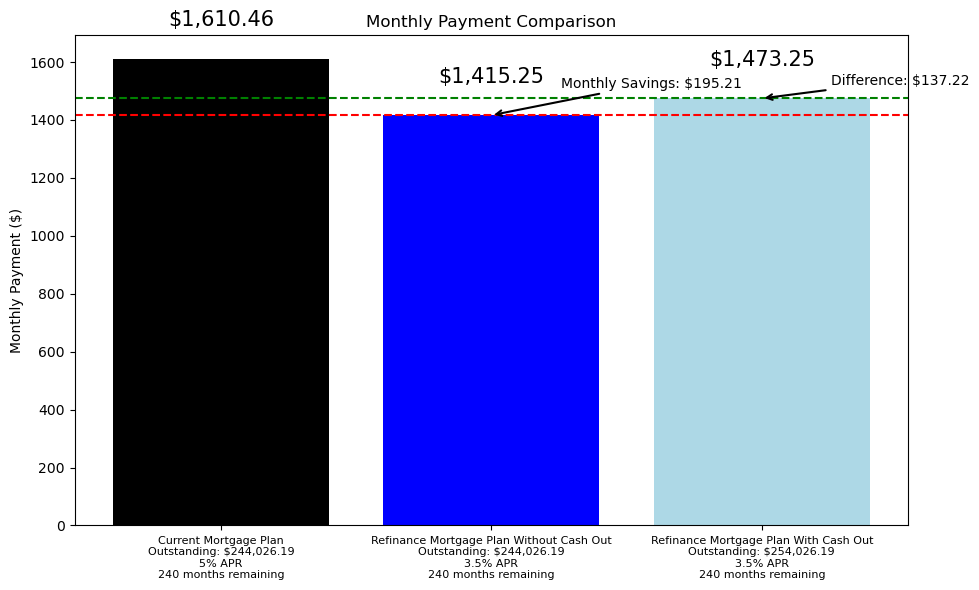

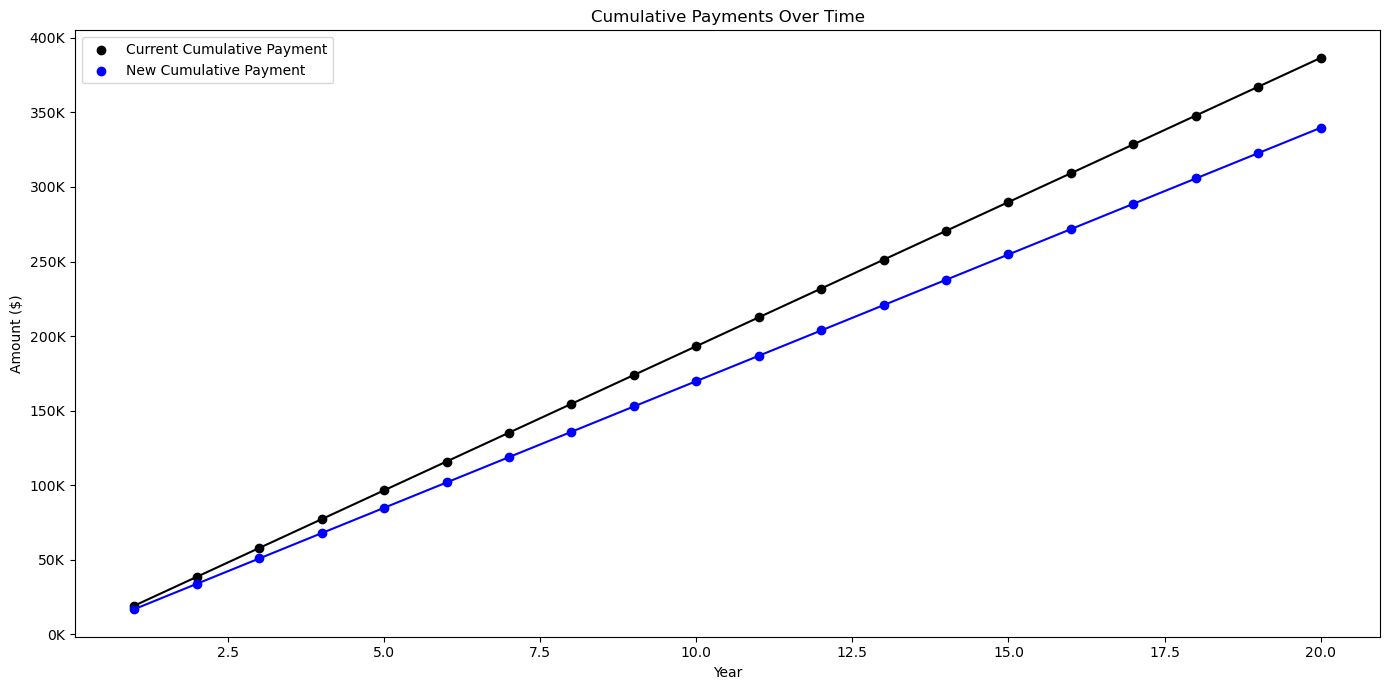

In [ ]:
payment_comparison(p, r, N, n, new_r, new_n, c, co)

<module 'matplotlib.pyplot' from '/Users/katkang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

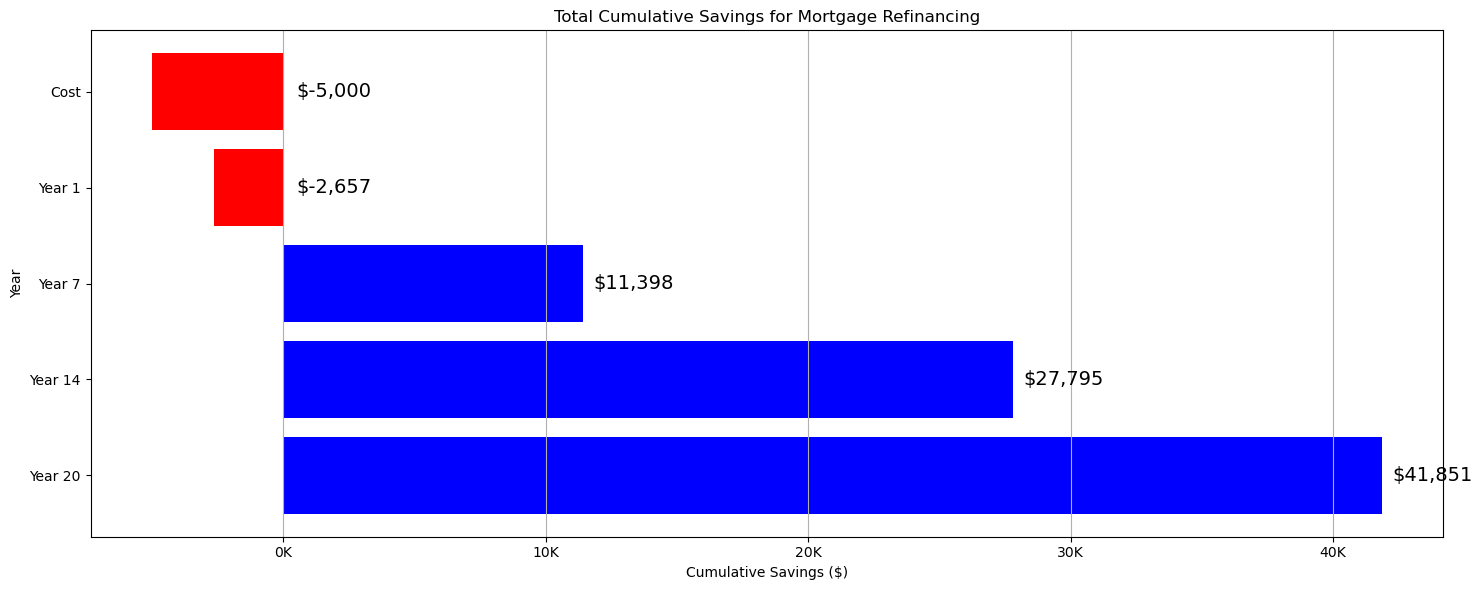

In [ ]:
plot_savings_interval(p, r, N, n, new_r, new_n, c, co, year_interval = 7)

<module 'matplotlib.pyplot' from '/Users/katkang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

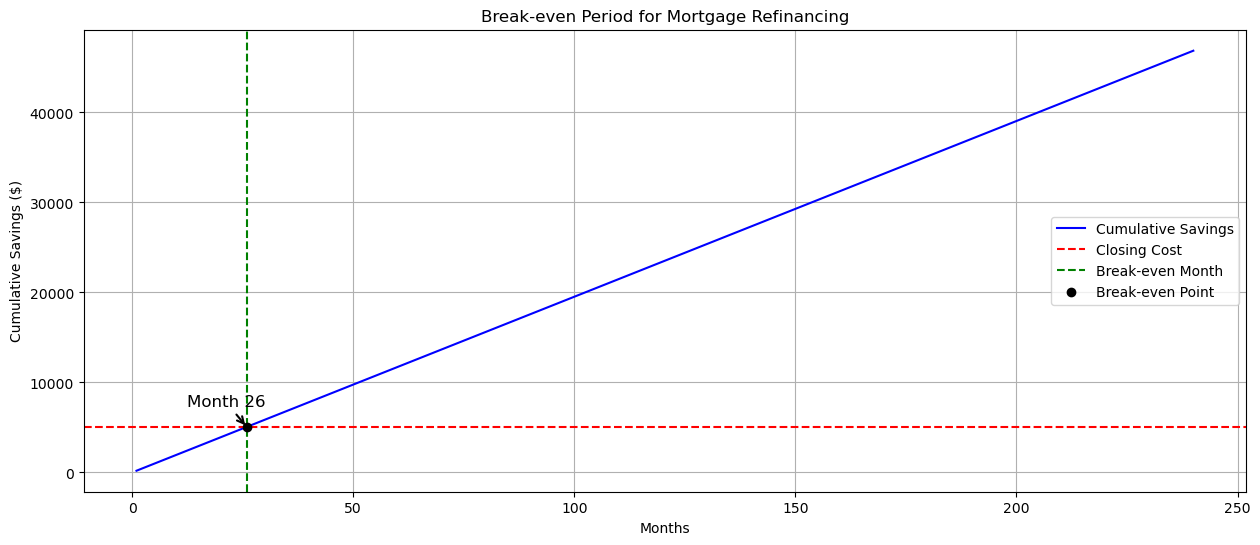

In [ ]:
plot_break_even_period(p, r, N, n, new_r, new_n, c, co)

# 4 Interface

In [ ]:
# Widgets
principal_widget = widgets.FloatText(value = 300000, description = "Principal ($):")
current_rate_widget = widgets.FloatText(value = 5, description = "Current APR (%):")
current_total_term_widget = widgets.IntText(value = 360, description = "Total Term (months):")
current_remaining_term_widget = widgets.IntText(value = 240, description = "Remaining Term (months):")
new_rate_widget = widgets.FloatText(value = 3.5, description = "New APR (%):")
new_remaining_term_widget = widgets.IntText(value = 240, description = "New Term (months):")
closing_cost_widget = widgets.FloatText(value = 5000, description = "Closing Cost ($):")
cash_out_widget = widgets.FloatText(value = 0, description = "Cash Out ($):")
year_interval_widget = widgets.IntText(value = 5, description = "Year Interval ($):")
analyze_button = widgets.Button(description = "Analyze")

market_rates_button = widgets.Button(description = 'Show Market Rates')
market_rates_output = widgets.Output()

# Results label
results_textarea = widgets.Textarea(disabled = True)
graph_output = widgets.Output()

def analyze(button):
    principal = principal_widget.value
    current_rate = current_rate_widget.value
    current_total_term = current_total_term_widget.value
    current_remaining_term = current_remaining_term_widget.value
    new_rate = new_rate_widget.value
    new_remaining_term = new_remaining_term_widget.value
    closing_cost = closing_cost_widget.value
    cash_out = cash_out_widget.value
    year_interval = year_interval_widget.value

    refinance_results = mortgage_refinance_calculation(principal, current_rate, current_total_term, current_remaining_term, new_rate, new_remaining_term, closing_cost, cash_out)

    # Results label for some key metrics
    results_text = f"""
    New Monthly Payment(Include the impact of cash out): ${refinance_results['new_monthly_payment_adjusted']:.2f}
    Monthly Savings: ${refinance_results['monthly_savings']:.2f}
    Break Even Point: {refinance_results['break_even_point']:.2f} months
    Cumulative Savings: ${refinance_results['monthly_savings'] * new_remaining_term:.2f}
    """
    results_textarea.value = results_text
    
    # Graphs
    with graph_output:
        clear_output(wait = True)
        payment_comparison(principal, current_rate, current_total_term, current_remaining_term, new_rate, new_remaining_term, closing_cost, cash_out)
        plot_savings_interval(principal, current_rate, current_total_term, current_remaining_term, new_rate, new_remaining_term, closing_cost, cash_out, year_interval)
        plot_break_even_period(principal, current_rate, current_total_term, current_remaining_term, new_rate, new_remaining_term, closing_cost, cash_out)
        plt.show()
        
analyze_button.on_click(analyze)
input_widgets = widgets.VBox([principal_widget, current_rate_widget, current_total_term_widget, current_remaining_term_widget,
                            new_rate_widget, new_remaining_term_widget, closing_cost_widget, cash_out_widget, year_interval_widget,
                            analyze_button])


def show_market_rates(button):
    # The Mortgage News Daily rate index is published daily (weekdays) around 4PM EST
    url = 'https://www.mortgagenewsdaily.com/mortgage-rates'
    soup = lovely_soup(url)
    rate_div= soup.find_all('div', class_ = 'col-sm-4 col-xs-12 rate-product')
    rate_type_div = soup.find_all('div', class_ = 'rate-product-name hidden-xs')
    rates = []
    rate_types = []
    for div in rate_div:
        rate = div.find('div', class_='rate')
        if rate is not None:
            rates.append(rate.text.strip())
    for div in rate_type_div:
        rate_type = div.a.text.strip()
        rate_types.append(rate_type)
    rate_df = pd.DataFrame({'rate_type': rate_types, 'rate': rates})

    with market_rates_output:
        clear_output(wait = True)
        display(rate_df)
market_rates_button.on_click(show_market_rates)

display(input_widgets, results_textarea, graph_output, market_rates_button, market_rates_output)


Textarea(value='', disabled=True)

Output()

Button(description='Show Market Rates', style=ButtonStyle())

Output()

---
The interactive plot isn't incorporated into the widget and needs manual adjustment

In [ ]:
p = 300000  # Principal
r = 5  # Current interest rate in percentage
N = 360  # Current total term in months
n = 222  # Current remaining term in months
new_r = 3.5  # New interest rate in percentage
new_n = 240  # New remaining term in months
c = 5000  # Closing cost
co = 10000 # Cash out
discount_rate = discount_rate  # Discount rate for NPV calculation

In [ ]:
def interactive_amortization_plot(p, r, N, n, new_r, new_n, c, co):
    
    '''
    Generate an interactive amortization plot comparing the cumulative payments of current and new mortgage plans.
    '''
    
    refinance_results = mortgage_refinance_calculation(p, r, N, n, new_r, new_n, c, co)
    outstanding_principal_balance = refinance_results['outstanding_principal_balance_adjusted'] - co
    
    current_schedule_df = loan_amortization_schedule(outstanding_principal_balance, r, n)
    new_schedule_df = loan_amortization_schedule(outstanding_principal_balance, new_r, new_n)
    
    current_schedule_df['Year'] = ((current_schedule_df['Month'] - 1) / 12).astype(int) + 1
    new_schedule_df['Year'] = ((new_schedule_df['Month'] - 1) / 12).astype(int) + 1
    
    current_grouped = current_schedule_df.groupby('Year').last()
    new_grouped = new_schedule_df.groupby('Year').last()
    
    merged_df = pd.concat([current_grouped.rename(columns = {'Cumulative Payment': 'Current Cumulative Payment', 
                                                             'Cumulative Interest Payment': 'Current Cumulative Interest Payment',
                                                             'Cumulative Principal Payment': 'Current Cumulative Principal Payment'}),
                           new_grouped.rename(columns = {'Cumulative Payment': 'New Cumulative Payment', 
                                                         'Cumulative Interest Payment': 'New Cumulative Interest Payment',
                                                         'Cumulative Principal Payment': 'New Cumulative Principal Payment'})], axis = 1).reset_index()

    fig = px.line(merged_df, x = 'Year', y = ['Current Cumulative Payment', 'New Cumulative Payment'], 
                  title = 'Cumulative Payments Over Time')

    # Hover data
    fig.update_traces(hoverinfo = 'all', hovertemplate = 
                      "Year: %{x}<br>" +
                      "Cumulative Payment: %{y:$}<br>" +
                      "Cumulative Interest Payment: %{customdata[0]:$}<br>" +
                      "Cumulative Principal Payment: %{customdata[1]:$}"
                      )
    
    fig.data[0]['customdata'] = merged_df[['Current Cumulative Interest Payment', 'Current Cumulative Principal Payment']].values
    fig.data[1]['customdata'] = merged_df[['New Cumulative Interest Payment', 'New Cumulative Principal Payment']].values

    return fig

interactive_amortization_plot(p, r, N, n, new_r, new_n, c, co)